In [1]:
import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia


In [2]:
plt.rcParams.update({"font.size": 15})


In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.P, J_ground=2, F1=3 / 2, F=2
    )
]

polarizations = [[couplings.polarization_Z]]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
    ground_mains=[
        1
        * states.CoupledBasisState(
            J=2,
            F=2,
            F1=5 / 2,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=0,
            P=+1,
            electronic_state=states.ElectronicState.X,
        )
    ],
    excited_mains=[
        1
        * states.CoupledBasisState(
            J=1,
            F=2,
            F1=3 / 2,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=1,
            P=-1,
            electronic_state=states.ElectronicState.B,
        )
    ],
)


In [4]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    PZ0=1,
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)


In [5]:
%%time
obe_system = lindblad.setup_OBE_system_transitions(
    trans, transition_selectors, 
    verbose=True,
    qn_compact= True,
    decay_channels = None
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


CPU times: total: 1min 3s
Wall time: 1min 25s


In [6]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)


In [7]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")


,"|B, J = 1, F₁ = 3/2, F = 2>"
states,
"|X, J = 0>",0.479671
"|X, J = 2>",0.520312
"|X, J = 4>",0.000017


In [8]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="mF")


,"|B, J = 1, F₁ = 3/2, F = 2>"
states,
"|X, J = 0, F₁ = 1/2, F = 1>",0.479671
"|X, J = 2, F₁ = 3/2, F = 1>",0.011839
"|X, J = 2, F₁ = 3/2, F = 2>",0.102837
"|X, J = 2, F₁ = 5/2, F = 2>",0.028282
"|X, J = 2, F₁ = 5/2, F = 3>",0.377355
"|X, J = 4, F₁ = 7/2, F = 3>",0.000017


In [9]:
ρ = np.zeros(obe_system.H_symbolic.shape, dtype=complex)

for J in [0, 2]:
    qn_select = states.QuantumSelector(J=J, electronic=states.ElectronicState.X)
    indices = qn_select.get_indices(obe_system.QN)
    thermal_population = utils.population.thermal_population(J, 6.3)
    for idx in indices:
        ρ[idx, idx] = thermal_population / indices.size

ρ /= np.trace(ρ)


In [10]:
power = 85e-3
intensity = power / (25.4e-3 * 25.4e-3)
rabi = utils.rabi.intensity_to_rabi(
    intensity, obe_system.couplings[0].main_coupling, D=2.6675506e-30
).real


In [11]:
odepars.Ωl0 = rabi

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)


In [12]:
results = lindblad_julia.do_simulation_single(problem, config=config)


In [13]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)


0.96 photons
gain = 3.1606821424279192


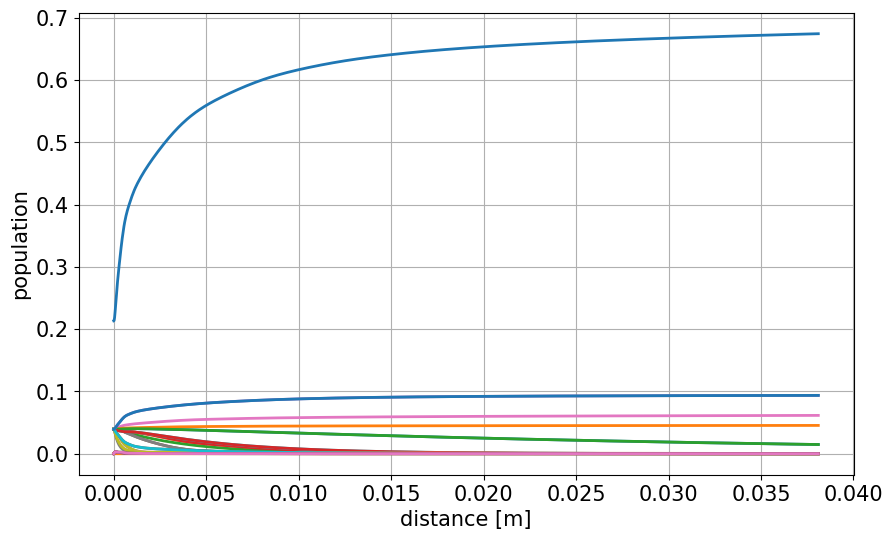

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results.t * odepars.vz, results.y.T, lw=2)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
# ax.legend(fontsize = 14)
ax.grid(True)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")
print(f"gain = {results.y[0,-1]/results.y[0,0]}")


# Scan Detuning

In [15]:
ratios = []
velocities = np.linspace(-2, 2, 21)
for vx in tqdm.tqdm(velocities):
    odepars.vx = vx

    problem = lindblad_julia.OBEProblem(
        odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz)
    )
    config = lindblad_julia.OBEProblemConfig(saveat=1e-6, save_everystep=False)

    results = lindblad_julia.do_simulation_single(problem, config=config)
    ratios.append(results.y[0, -1] / results.y[0, 0])


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


INFO:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral


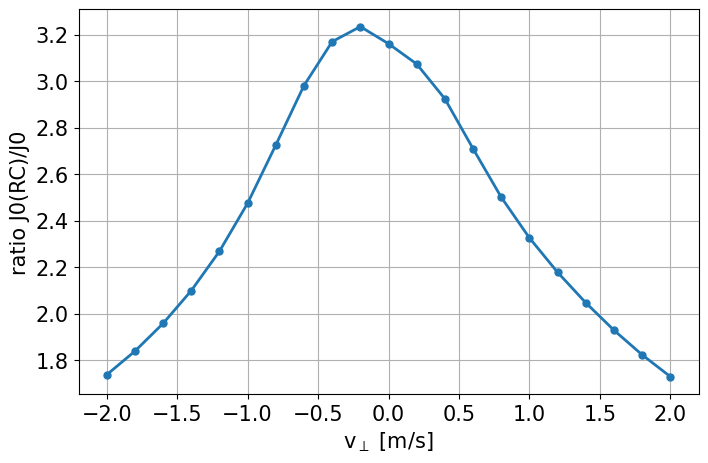

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(velocities, ratios, ".-", lw=2, ms=10)

ax.set_xlabel("v$_\perp$ [m/s]")
ax.set_ylabel("ratio J0(RC)/J0")

ax.grid(True)


# Scan Rabi and Detuning

In [17]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices


In [18]:
state_selector = states.QuantumSelector(J=[0], electronic=states.ElectronicState.X)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")


In [19]:
rabis = np.linspace(0.01, 1, 21) * hamiltonian.Γ
velocities = np.linspace(-2, 2, 21)


In [20]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    save_everystep=False,
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5))

scan_values = [velocities, rabis]
parameters = ["vx", "Ωl0"]

output_func = lindblad_julia.setup_ratio_calculation_state_idxs()


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)


In [21]:
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


In [22]:
results = lindblad_julia.get_results_parameter_scan(ensemble_problem)


INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral


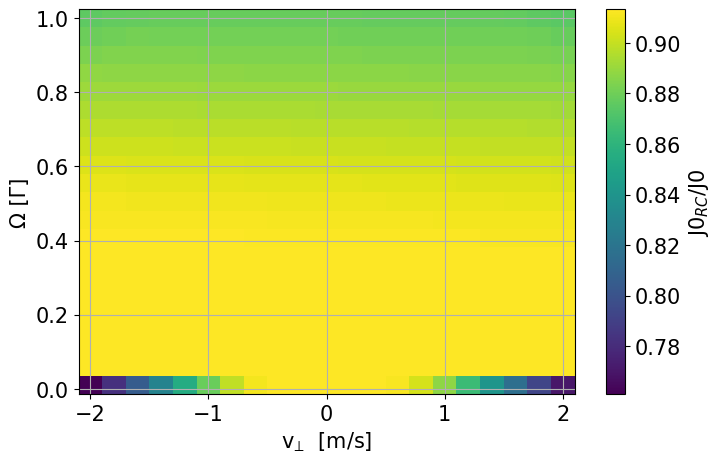

In [23]:
X, Y = results.scan_values
z = results.results

fig, ax = plt.subplots(figsize=(8, 5))
c = ax.pcolormesh(X, Y / hamiltonian.Γ, z)

cbar = fig.colorbar(c)

ax.set_xlabel("v$_⟂$  [m/s]")
ax.set_ylabel("Ω [Γ]")
cbar.ax.set_ylabel("J0$_{RC}$/J0")
ax.grid(True)
